In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, make_scorer

In [89]:
train_dataset_path = "./data/mnist_train.csv"
test_dataset_path = "./data/mnist_test.csv"
max_pixel_intensity = 255

# EDA

## Read datasets

In [90]:
train = pd.read_csv(train_dataset_path)
test = pd.read_csv(test_dataset_path)

In [91]:
train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [93]:
train.shape

(60000, 785)

## Summary statistics

In [94]:
train.describe()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
count,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,4.453933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,2.889270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


## Check for missing values

In [95]:
def check_missing_values(df: pd.DataFrame) -> bool:
    has_missing_values = df.isna().any().any()
    print(f"Dataframe has missing values: {has_missing_values}")
    return has_missing_values

In [96]:
check_missing_values(df=train)

Dataframe has missing values: False


False

## Calculate feature matrix sparsity

In [97]:
def calculate_sparsity(df: pd.DataFrame) -> float:
    sparsity = ((df == 0).sum().sum() / df.size) * 100
    print(f"Dataframe is {round(sparsity, 2)}% sparse")
    return sparsity

In [98]:
calculate_sparsity(df=train)

Dataframe is 80.79% sparse


80.78931422505308

# Preprocessing

## Drop features (pixels) with constant values

In [99]:
def get_constant_pixels(df: pd.DataFrame):
    constant_pixels = [col for col in df.columns if df[col].max() == df[col].min()]
    print(f"Columns with constant pixel values: {constant_pixels}")
    return constant_pixels

In [100]:
train.drop(columns=get_constant_pixels(train), inplace=True)

Columns with constant pixel values: ['1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9', '1x10', '1x11', '1x12', '1x17', '1x18', '1x19', '1x20', '1x21', '1x22', '1x23', '1x24', '1x25', '1x26', '1x27', '1x28', '2x1', '2x2', '2x3', '2x4', '2x25', '2x26', '2x27', '2x28', '3x1', '3x2', '3x27', '3x28', '4x1', '4x2', '4x28', '5x1', '6x1', '6x2', '7x1', '18x1', '21x1', '24x1', '24x2', '24x28', '25x1', '25x2', '25x28', '26x1', '26x2', '26x28', '27x1', '27x2', '27x3', '27x27', '27x28', '28x1', '28x2', '28x3', '28x4', '28x25', '28x26', '28x27', '28x28']


In [101]:
x, y = train.drop(columns=['label']), train.pop(item='label')

## Scale and normalize

In [102]:
x = x / max_pixel_intensity

In [103]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

# Visualizations

## Check if labels are balanced

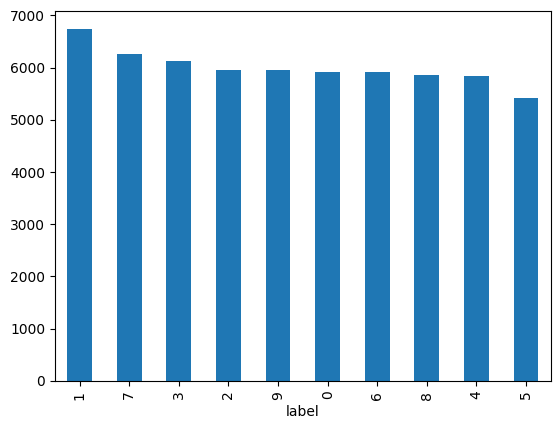

In [104]:
y.value_counts().plot(kind='bar')
plt.show()

## Dimensionality reduction (n_components = 2)

In [105]:
dimensionality_reduction_methods: dict = {
    "PCA": PCA(n_components=2),
    "t-SNE": TSNE(n_components=2),
    "UMAP": UMAP(n_components=2)
}

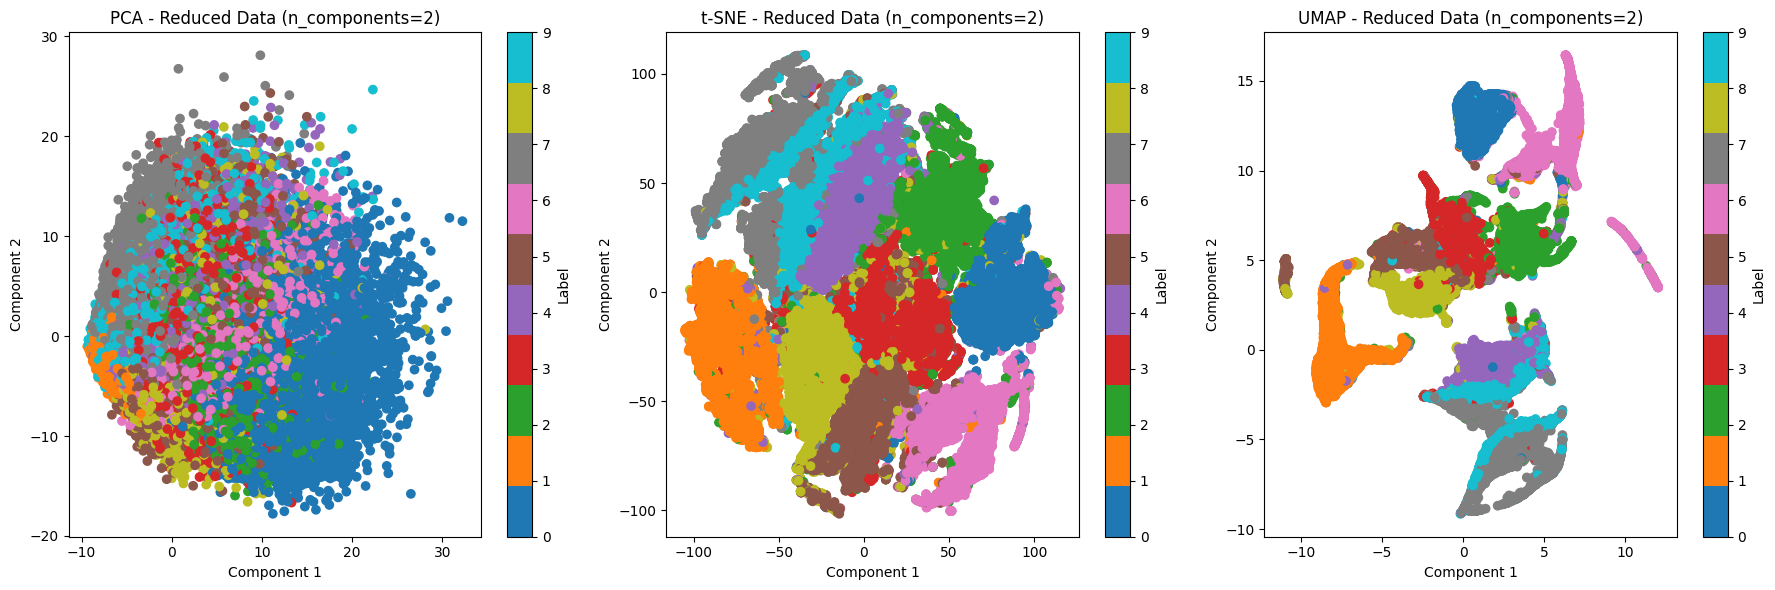

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (method_name, method_instance) in enumerate(dimensionality_reduction_methods.items()):
    reduced_data = method_instance.fit_transform(x)

    ax = axes[i]
    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y, cmap='tab10')
    ax.set_title(f'{method_name} - Reduced Data (n_components=2)')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    fig.colorbar(scatter, ax=ax, label='Label')

plt.tight_layout()
plt.show()

### PCA

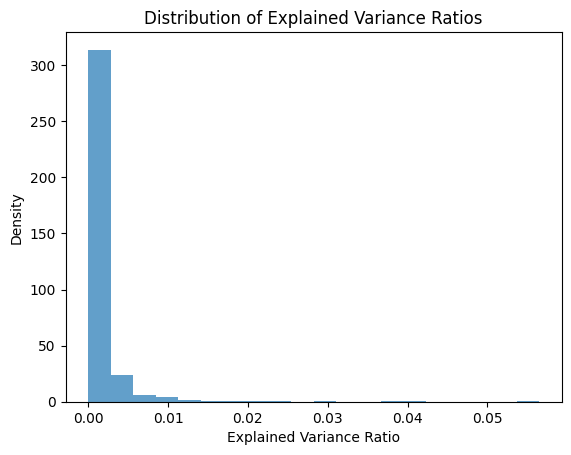

In [107]:
pca = PCA()
pca.fit(x)
explained_variance_ratios = pca.explained_variance_ratio_
plt.hist(explained_variance_ratios, bins=20, density=True, alpha=0.7)
plt.title('Distribution of Explained Variance Ratios')
plt.xlabel('Explained Variance Ratio')
plt.ylabel('Density')
plt.show()

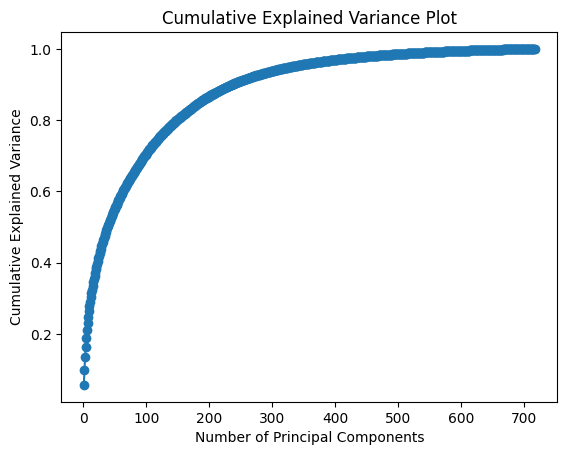

In [108]:
cumulative_variance = np.cumsum(explained_variance_ratios)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.show()

## Hyperparameter tuning

### t-SNE

In [157]:
parameter_search_space = [
    {"method_name": "t-SNE",
     "method_instance": TSNE(n_components=2),
     "parameters": {
         "perplexity": list(range(5, 51, 5)),
         "learning_rate": list(range(100, 1001, 100)),
         "metric": ["euclidean", "cityblock", "chebyshev", "minkowski"]
     }},
    {"method_name": "UMAP",
     "method_instance": UMAP(n_components=2),
     "parameters": {
         "n_neighbors": list(range(10, 31, 5)),
         "min_dist": [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5],
         "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]
     }}
]

In [158]:
scoring_metrics = {
    'ARI': make_scorer(adjusted_rand_score, greater_is_better=True),
    'NMI': make_scorer(normalized_mutual_info_score, greater_is_better=True)
}

In [159]:
best_models, best_scores, trained_models = {}, {}, {}

for method in parameter_search_space:
    print(f"Performing hyperparameter tuning for {method['method_name']}")

    random_search = RandomizedSearchCV(
        estimator=method["method_instance"],
        param_distributions=method["parameters"],
        n_iter=10,
        n_jobs=-1,
        scoring=scoring_metrics,
        cv=6,
        random_state=42,
        refit=False
    )

    random_search.fit(x, y)

    best_models[method_name] = random_search.best_estimator_
    best_scores[method_name] = random_search.best_score_
    trained_models[method_name] = random_search.cv_results_['params']

    print(f"Best score for {method_name}: {best_scores[method_name]:.4f}\n")

for method_name, score in best_scores.items():
    print(f"Best score for {method_name}: {score:.4f}")

Performing hyperparameter tuning for t-SNE


KeyboardInterrupt: 